<a href="https://colab.research.google.com/github/innosoft21/workspace/blob/main/tensorflow_R/Titanic_DecisionTree_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

titanic3.csv 의사결정나무, 랜덤포레스트


In [3]:
#전처리 후 의사결정나무, 랜덤포레스트 진행
titanic <- read.csv("titanic3.csv")  #데이터 불러오기
titanic <- titanic[ ,!names(titanic) %in% c("boat","body","home.dest") ] #불필요한 변수 제거

titanic$pclass <- as.factor(titanic$pclass) #데이터 타입 변환
titanic$sex <- as.factor(titanic$sex)
titanic$embarked <- as.factor(titanic$embarked)
titanic$survived <- factor(titanic$survived, levels=c(0,1), labels=c("dead","survived"))
levels(titanic$embarked)[1] <- NA #빈칸 NA로 대치

#install.packages(dlookr) #패키지 설치
#library(dlookr) #패키지 로딩
#diagnose(titanic) #결측치 확인
#titanic$age <- imputate_na(titanic, age, method = "mean") #결측치 대치

titanic <- titanic[complete.cases(titanic[ ,9]), ] #결측치 제거
titanic <- titanic[complete.cases(titanic[ ,11]), ] #결측치 제거

연속형 변수를 범주형 변수로 변환하는 방법에는 대표적으로 cut(), ifelse(), within() 함수를 사용하는 것이 있다.

개인적으로 이 셋 중에 within() 함수를 가장 자주 사용하는 편

1. 파생변수 추가
 
1-1. 연속형 변수를 범주형 변수로 변환

In [8]:
titanic <- within( titanic, {
  age_1 = character(0) 
  age_1[ age <= 16 ] = "A" 
  age_1[ age >16 & age <= 32 ] = "B" 
  age_1[ age >32 & age <= 48 ] = "C" 
  age_1[ age >48 & age <= 64 ] = "D" 
  age_1[ age >64 ] = "E"
  age_1 = factor(age_1, level = c("A", "B", "C", "D", "E"))
})

In [9]:
summary(titanic$age_1)

A    B    C    D    E NA's 
 134  524  268  104   13  263

1-2. 두 변수를 합쳐 파생변수 추가

In [15]:
library(dplyr)
titanic <- titanic %>%
            mutate(Family=sibsp+parch)
str(titanic)

'data.frame':	1306 obs. of  13 variables:
 $ pclass  : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ survived: Factor w/ 2 levels "dead","survived": 2 2 1 1 1 2 2 1 2 1 ...
 $ name    : chr  "Allen, Miss. Elisabeth Walton" "Allison, Master. Hudson Trevor" "Allison, Miss. Helen Loraine" "Allison, Mr. Hudson Joshua Creighton" ...
 $ sex     : Factor w/ 2 levels "female","male": 1 2 1 2 1 2 1 2 1 2 ...
 $ age     : num  29 0.92 2 30 25 48 63 39 53 71 ...
 $ sibsp   : int  0 1 1 1 1 0 1 0 2 0 ...
 $ parch   : int  0 2 2 2 2 0 0 0 0 0 ...
 $ ticket  : chr  "24160" "113781" "113781" "113781" ...
 $ fare    : num  211 152 152 152 152 ...
 $ cabin   : chr  "B5" "C22 C26" "C22 C26" "C22 C26" ...
 $ embarked: Factor w/ 3 levels "C","Q","S": 3 3 3 3 3 3 3 3 3 1 ...
 $ age_1   : Factor w/ 5 levels "A","B","C","D",..: 2 1 1 2 2 3 4 3 4 5 ...
 $ Family  : int  0 3 3 3 3 0 1 0 2 0 ...


2. 데이터 분할 및 변수 선택

In [16]:
set.seed(1234)
idx<- sample(1:nrow(titanic), size=nrow(titanic)*0.7,replace=FALSE)
train <- titanic[idx,]
test <- titanic[-idx,]
nrow(train)
nrow(test)

[1] 914

[1] 392

모델링하기 전에 종속변수 survived와 독립변수 pclass, sex, age_1, Family, fare, embarked만 추출

In [17]:
train_1 <- train[,c("pclass","survived","sex","age_1","fare","embarked","Family")]
test_1 <- test[,c("pclass","survived","sex","age_1","fare","embarked","Family")]
str(test_1)

'data.frame':	392 obs. of  7 variables:
 $ pclass  : Factor w/ 3 levels "1","2","3": 1 1 1 1 1 1 1 1 1 1 ...
 $ survived: Factor w/ 2 levels "dead","survived": 1 1 1 2 2 2 2 1 2 1 ...
 $ sex     : Factor w/ 2 levels "female","male": 1 1 2 1 1 1 2 2 1 2 ...
 $ age_1   : Factor w/ 5 levels "A","B","C","D",..: 1 2 3 4 2 2 5 NA 4 3 ...
 $ fare    : num  151.6 151.6 0 51.5 227.5 ...
 $ embarked: Factor w/ 3 levels "C","Q","S": 3 3 3 3 1 3 3 3 1 1 ...
 $ Family  : int  3 3 0 2 1 0 0 0 1 0 ...


3. 모델 설계 및 학습 

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



n= 914 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 914 347 dead (0.62035011 0.37964989)  
   2) sex=male 580 104 dead (0.82068966 0.17931034)  
     4) age_1=B,C,D,E 534  83 dead (0.84456929 0.15543071) *
     5) age_1=A 46  21 dead (0.54347826 0.45652174)  
      10) Family>=3.5 17   0 dead (1.00000000 0.00000000) *
      11) Family< 3.5 29   8 survived (0.27586207 0.72413793) *
   3) sex=female 334  91 survived (0.27245509 0.72754491)  
     6) pclass=3 158  77 dead (0.51265823 0.48734177)  
      12) fare>=23.35 25   2 dead (0.92000000 0.08000000) *
      13) fare< 23.35 133  58 survived (0.43609023 0.56390977) *
     7) pclass=1,2 176  10 survived (0.05681818 0.94318182) *

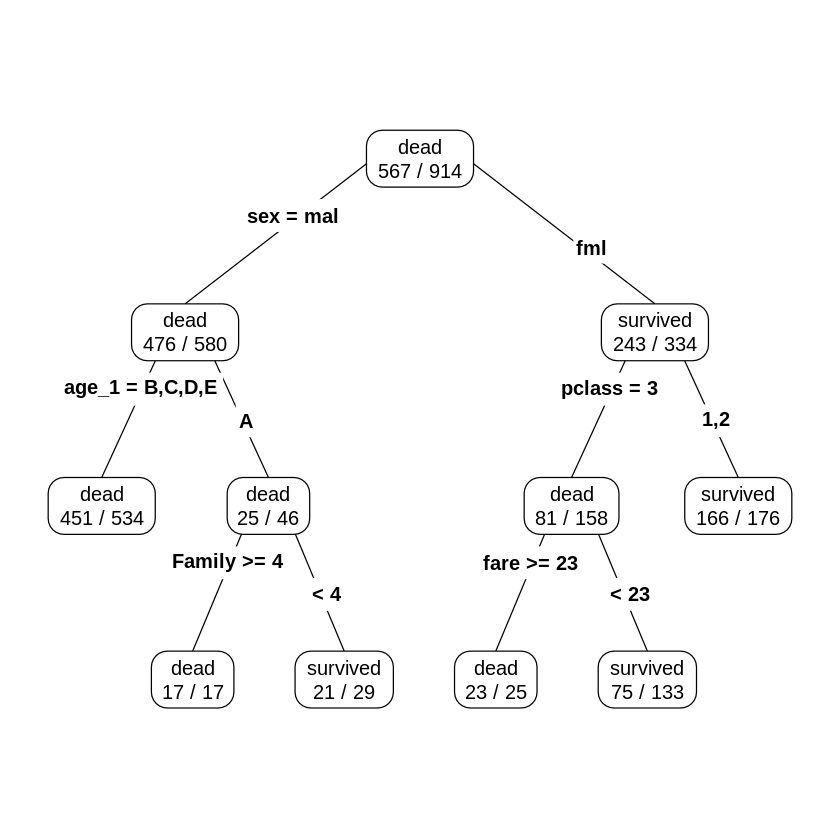

In [19]:
install.packages(c("rpart","rpart.plot"))
library(rpart)
library(rpart.plot)
dt.model <- rpart(survived~.,       #종속변수는 survived, 독립변수는 모든 변수
            method="class",         # method는 분류인 "class" 선택
            data=train_1,
            control=rpart.control(maxdepth=4,       # 의사결정나무의 최대 깊이는 4개까지
                                  minsplit=15))    # 노드에서 최소 관측치는 15개 이상
dt.model
prp(dt.model, type=4, extra=2)

총 915명의 승객 중 563명을 사망자(dead)로 분류했으며, 성별이 여자(fml)인 332명 중 238명이 생존자(survived)로 분류되었음을 의미한다. prp 함수는 rpart.plot 패키지에 속한 함수이며, type, extra 등의 인자를 사용하여 그래프 모양을 바꿀 수 있다. 

성과분석 : F1-score

In [ ]:
#install.packages("caret")
library(caret)
pred.dt <- predict(dt.model, test_1[,-2],type="class")
confusionMatrix(data=pred.dt, reference=test_1[,2], positive='survived')

In [ ]:
precision <- posPredValue(pred.dt,test_1[,2], positive="survived")
recall <- sensitivity(pred.dt,test_1[,2], positive="survived")
F1_score <- (2 * precision * recall) / (precision + recall)
precision
recall
F1

성과분석 : ROC Curve

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’




[[1]]
[1] 0.7543623

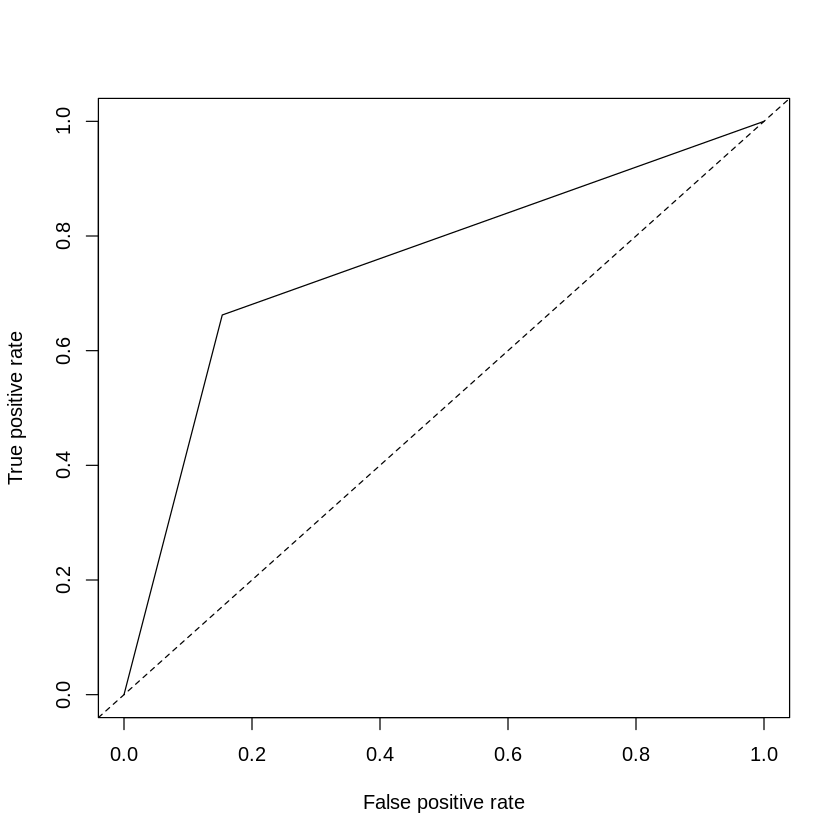

In [24]:
#install.packages("ROCR")
library(ROCR)
pred.dt.roc<- prediction(as.numeric(pred.dt),as.numeric(test_1[,2]))
plot(performance(pred.dt.roc,"tpr","fpr"))
abline(a=0,b=1,lty=2,col="black")
performance(pred.dt.roc,"auc")@y.values

의사결정 나무 분석 결과의 AUC값은 0.7881(78.81%)로 모델의 성능은 보통 수준으로 나타난다.

랜덤 포레스트(Random Forest)

In [ ]:
#install.packages("randomForest")
library(randomForest)
rf.model <- randomForest(survived~.,data=train_1)
print(rf.model)

성과분석 : F1-score

In [ ]:
pred.rf <- predict(rf.model,test_1[,-2],type="class")
confusionMatrix(data=pred.rf, reference=test_1[,2],positive="survived")

In [ ]:
precision <- posPredValue(pred.rf,test_1[,2], positive="survived")
recall <- sensitivity(pred.rf,test_1[,2], positive="survived")
F1 <- (2 * precision * recall) / (precision + recall)
precision
recall
F1

In [ ]:
pred.rf.roc<- prediction(as.numeric(pred.rf),as.numeric(test_1[,2]))
plot(performance(pred.rf.roc,"tpr","fpr"))
abline(a=0,b=1,lty=2,col="black")
performance(pred.rf.roc,"auc")@y.values

두 모델의 성과를 비교해보면, 의사결정 나무의 분석결과가 정분류율은 약 81%로 랜덤포레스트보다 2%정도 높게 나타나고, F1-score, AUC 값에서도 의사결정나무 모델의 성능이 좋게 나타났다.